# KUESKI CHALLENGE 5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import __version__
print(__version__)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)
import tensorflow_data_validation as dv
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

4.14.3


IMPORT DATA

In [2]:
df=pd.read_excel('/Users/fabiobisognin/Desktop/CHALLENGE5.xlsx')
december= pd.read_excel('/Users/fabiobisognin/Desktop/December.xlsx')

USEFULL TRANSFORMATION

In [3]:
data=df#leave a copy of the original

In [4]:
data['status']= data['status'].replace('loan', '0')
data['status']= data['status'].replace('paid', '1')
data['status']=data['status'].astype(int)

#fully_paid_on_time ADD COLUMN
data['fully_ontime']=data['loan_amount']-data['principalpaid_on_time']+1
data.loc[data['fully_ontime']>1, 'fully_ontime']=0

#total_ontime ADD COLUMN
data['total_late']=data['principalpal_until_past_due_7_days']-data['principalpaid_on_time']
data.loc[data['total_late'] == data['principalpaid_on_time'], 'total_late'] = 0

#fully_paid_late  ADD COLUMN
data['fully_late']=data['loan_amount']-data['principalpal_until_past_due_7_days']+1
data.loc[data['fully_late']>1, 'fully_late']=0

#experiment_control SPLIT DATASET
exp=data.loc[data['experiment'] == 'experiment']
cont=data.loc[data['experiment'] == 'control']



In [5]:
experiment=exp[['status', 'due_date', 'paid_date', 'loan_amount',  'risk_score', 'gender', 'age', 'dependants', 'device', 'urban_city' ]]
experiment['gender']=experiment['gender'].astype(str)
experiment['urban_city']=experiment['urban_city'].astype(str)
experiment['device']=experiment['device'].astype(str)

control=cont[['status', 'due_date', 'paid_date', 'loan_amount',  'risk_score', 'gender', 'age', 'dependants', 'device', 'urban_city' ]]
control['gender']=control['gender'].astype(str)
control['urban_city']=control['urban_city'].astype(str)
control['device']=control['device'].astype(str)


<ipython-input-5-ff8e94c4fbd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment['gender']=experiment['gender'].astype(str)
<ipython-input-5-ff8e94c4fbd4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment['urban_city']=experiment['urban_city'].astype(str)
<ipython-input-5-ff8e94c4fbd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

# 1 - Is recovery affected if we do not call versus calling every day until the loan is paid?

Recovery as the loan is fully paid.

In [6]:
#prueba hipotesis t o z
print(f"The mean of the fully paid loan when we don't call is {round(exp.status.mean()*100, 2)}%")
print(f"The mean of the fully paid loan when we call is {round(cont.status.mean()*100, 2)}%")
print(f"If we call the loan the full recovery increases by {round((cont.status.mean()*100)-round(exp.status.mean()*100), 2)}% of the potential loss")

The mean of the fully paid loan when we don't call is 84.2%
The mean of the fully paid loan when we call is 85.54%
If we call the loan the full recovery increases by 1.54% of the potential loss


Recovery as total paid on time

In [7]:
print(f"The mean of the fully paid on time loan when we don't call is {round(exp.fully_ontime.mean()*100, 2)}%")
print(f"The mean of the fully paid on time loan when we call is {round(cont.fully_ontime.mean()*100, 2)}%")
print(f"If we call the loan the full recovery on time increases by {round((cont.fully_ontime.mean()*100)-(exp.fully_ontime.mean()*100), 2)}% of the potential loss")

The mean of the fully paid on time loan when we don't call is 53.51%
The mean of the fully paid on time loan when we call is 53.81%
If we call the loan the full recovery on time increases by 0.3% of the potential loss


Recovery as total paid 7 days past due

In [8]:
print(f"The mean of the fully late paid loan when we don't call is {round(exp.fully_late.mean()*100, 2)}%")
print(f"The mean of the fully late paid loan when we call is {round(cont.fully_late.mean()*100, 2)}%")
print(f"If we call the loan the full late recovery increases by {round((cont.fully_late.mean()*100)-(exp.fully_late.mean()*100), 2)}% of the potential loss")

The mean of the fully late paid loan when we don't call is 80.66%
The mean of the fully late paid loan when we call is 81.29%
If we call the loan the full late recovery increases by 0.64% of the potential loss


IS THERE ANY DIFFERENCE IF WE CALL OR NOT TO THE CUSTOMERS EVERYDAY?
STATISTICAL DESCRIPTION

In [9]:
ex = dv.generate_statistics_from_dataframe(experiment)
ct = dv.generate_statistics_from_dataframe(control)
dv.visualize_statistics(lhs_statistics=ex,
                        rhs_statistics=ct)

T-TEST NULL HIPOTESIS: IF WE CALL EVERYDAY THE CHANCES TO RECOVER THE LOAN ARE NOT HIGHER

In [10]:
exp_recovery= np.asarray(data[['principalpal_until_past_due_7_days']])
cont_recovery= np.asarray(data[['principalpal_until_past_due_7_days']])

In [11]:

def plot_distribution(inp):
    plt.figure()
    ax = sns.distplot(inp)
    plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    return plt.figure

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


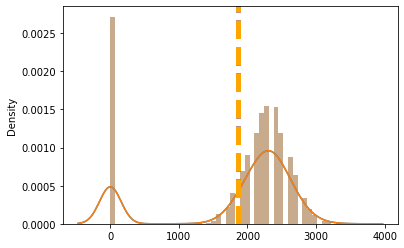

In [12]:
plt.figure()
ax1 = sns.distplot(exp_recovery)
ax2 = sns.distplot(cont_recovery)
plt.axvline(np.mean(exp_recovery), color='b', linestyle='dashed', linewidth=5)
plt.axvline(np.mean(cont_recovery), color='orange', linestyle='dashed', linewidth=5)

In [13]:
def compare_2_groups(arr_1, arr_2, alpha, sample_size):
    stat, p = ttest_ind(arr_1, arr_2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

In [14]:
sample_size = 500
exp_sampled = np.random.choice(len(exp_recovery), sample_size)
cont_sampled = np.random.choice(len(cont_recovery), sample_size)
compare_2_groups(exp_sampled, cont_sampled, 0.05, sample_size)

Statistics=-0.757, p=0.449
Same distributions (fail to reject H0)


As P-Value is higer than 0.05 so it is not statistically significant and indicates strong evidence for the null hypothesis. 
This means that if we call everyday our customers the chances to recover the credit are not statisticly higer than just calling them on the 6 days past due.

# 2. Which group had the greatest loss rate?

In [16]:

data['loss_rate']=(data['loan_amount']-data['principalpal_until_past_due_7_days'])/(data['loan_amount'])


In [17]:

data.loss_rate.value_counts()

0.0000    6417
1.0000    1507
Name: loss_rate, dtype: int64

Partial loan recovery do not exist so I split into two groups

In [18]:
stat=data
stat=pd.get_dummies(stat, columns=['status','gender', 'experiment', 'device', 'loan_usage', 'urban_city'], prefix = ['','', '','','',''])

CORRELATION ANALISIS

<AxesSubplot:>

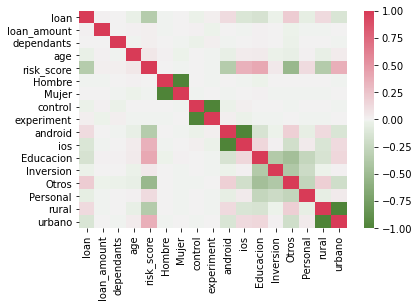

In [19]:
stat_loan=stat[['_0','loan_amount', 'dependants','age', 'risk_score', '_Hombre','_Mujer', '_control','_experiment','_android', '_ios', '_Educacion', '_Inversion', '_Otros', '_Personal', '_rural', '_urbano']]
stat_loan.columns=['loan','loan_amount', 'dependants','age', 'risk_score', 'Hombre','Mujer', 'control','experiment','android', 'ios', 'Educacion', 'Inversion', 'Otros', 'Personal', 'rural', 'urbano']
cmap = sns.diverging_palette(120,6,as_cmap=True)
sns.heatmap(stat_loan.corr(),cmap=cmap)

IF WE CHECK THE CORRELATION GRAPHIC WE CAN SEE THAT LOAN STATUS RELATES TO:
- HIGH RISK RATE (quite obvious)
- 'OTROS' LOAN USAGE
- FROM RURAL AREA
- USE ANDROID DEVICE 
HOWEVER THOSE CORRELATIONS ARE QUITE WEAK IN BOTH WAYS (POSITIVE AND NEGATIVE). WE CAN SEE THESE INTO THE OTHER CHARTS HERE BELOW.

In [21]:
loan=data[['experiment', 'loan_amount', 'dependants','device', 'loan_usage', 'age', 'risk_score', 'gender', 'urban_city']][data['status']==0]
paid=data[['experiment', 'loan_amount', 'dependants','device', 'loan_usage', 'age', 'risk_score', 'gender', 'urban_city']][data['status']==1]


In [22]:
l = dv.generate_statistics_from_dataframe(loan)
p = dv.generate_statistics_from_dataframe(paid)
dv.visualize_statistics(lhs_statistics=l,
                        rhs_statistics=p)

# 3. What is the expected recovery if we don’t call until 7 days past due?

I START BY ANALYZING THE EXPERIMENT GROUP AND CHECK WHAT HAPPENS WITHIN THE NEXT 2 DAYS. THEN I APPLY A LINEAR PREDICTION TO ANSWER THE QUESTION.

In [23]:
lost= exp[exp['principalpal_until_past_due_7_days']==0]
recovered=exp[exp['principalpal_until_past_due_7_days']!=0]

In [24]:
recovered['pay_difference']=recovered['paid_date']-recovered['due_date']

<ipython-input-24-a33f041ffa27>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
recovery=recovered.groupby('pay_difference').agg({'loan_amount':'sum', 'principalpaid_on_time':'sum', 'total_late':'sum'}).reset_index()
recovery['percentage']=recovery['loan_amount']*100/recovery['loan_amount'].sum()
recovery['pay_difference']=recovery['pay_difference'].astype(str).map(lambda x: str(x)[:-4])
recovery['pay_difference']=recovery['pay_difference'].astype(int)


DISPLAY CREDIT RECOVERY DISTRIBUTION

<AxesSubplot:xlabel='pay_difference'>

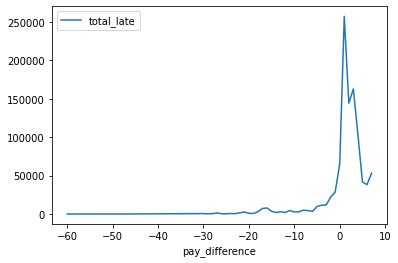

In [26]:
recovery.plot(x='pay_difference', y='total_late')

LINEAR ANALIS PREDICTION

In [28]:
from fbprophet import Prophet

In [29]:
r=recovery[['total_late', 'pay_difference']]
r=r.tail(7)
r=r[:-1]


In [30]:

r['date'] = ['1970-01-01', '1970-01-02', '1970-01-03',\
             '1970-01-04', '1970-01-05', '1970-01-06']
r=r[['total_late', 'date']]

r.rename(columns = {'total_late':'y', 'date':'ds'}, inplace = True)


In [31]:
m = Prophet(interval_width=0.95)
model = m.fit(r)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


In [32]:
future = m.make_future_dataframe(periods=100,freq='D')
forecast = m.predict(future)
forecast.head(7)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01,229046.9126,181015.1615,276782.7375,229046.9126,229046.9126,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,229046.9126
1,1970-01-02,187312.6598,139092.4230,236039.2995,187312.6598,187312.6598,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,187312.6598
2,1970-01-03,145578.4071,98799.4248,194506.2203,145578.4071,145578.4071,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,145578.4071
3,1970-01-04,103844.1545,57815.3808,152322.9214,103844.1545,103844.1545,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,103844.1545
4,1970-01-05,62109.9019,16643.2384,111101.3224,62109.9019,62109.9019,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,62109.9019
5,1970-01-06,20375.6493,-27223.6505,68388.4965,20375.6493,20375.6493,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20375.6493
6,1970-01-07,-21358.6032,-69876.0267,26496.2179,-21358.6040,-21358.6024,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-21358.6032


The model predict a -x payment for the 7th days, so I assume the amount paied on the 7th day is 0$.

In [33]:
rec_7=recovery['principalpaid_on_time'].sum()-recovery['total_late'][:-1].sum()
print(f"If we do not call until 7 days past due recovery would be ${rec_7} ")

If we do not call until 7 days past due recovery would be $5224634 


# 4. Assuming the distribution of recovery will be the same for december. 
What will be the daily recovery for this month based on the expected disbursement?

I ASSUME FOR THIS PROBLEM THAT:
- I DON'T KNOW WHAT SHOULD BE PAIED (LATE) DURING THE FIRST 6 DAYS OF THE MONTH
- I CANNOT APPLY A DAILY VARIATION FACTOR BECAUSE THE FIRST DATASET ONLY INCLUDE 5 DAYS OF DUE DATES, WHICH DOES NOT GIVE ME ENOUGH GRANULARITY TO GO FURTHER WITH MY ANALYSIS

FOR THIS TASK I WILL CALCULATE THE AVERAGE PERCENTAGE OF TOTAL LOAN RECOVERY FOR EACH DAY OF THE MONTH AND APPLY THIS TO THE DAILY LOAN AMOUNT.

In [35]:
tot_rec=data['loan_amount'].sum()
rec_0=(data['principalpal_until_past_due_7_days'].sum())*100/tot_rec
rec_1=(recovery.iloc[33]['total_late']*100/tot_rec)
rec_2=(recovery.iloc[34]['total_late']*100/tot_rec)
rec_3=(recovery.iloc[35]['total_late']*100/tot_rec)
rec_4=(recovery.iloc[36]['total_late']*100/tot_rec)
rec_5=(recovery.iloc[37]['total_late']*100/tot_rec)
rec_6=(recovery.iloc[38]['total_late']*100/tot_rec)
rec_7=(recovery.iloc[39]['total_late']*100/tot_rec)


In [36]:
r_1=rec_0+rec_1
r_2=rec_0+rec_1+rec_2
r_3=rec_0+rec_1+rec_2+rec_3
r_4=rec_0+rec_1+rec_2+rec_3+rec_4
r_5=rec_0+rec_1+rec_2+rec_3+rec_4+rec_5
r_6=rec_0+rec_1+rec_2+rec_3+rec_4+rec_5+rec_6
r_7=rec_0+rec_1+rec_2+rec_3+rec_4+rec_5+rec_6+rec_7


In [61]:
december['fix%']=[r_1, r_2, r_3, r_4, r_5, r_6, r_7, r_7, r_7,\
                r_7, r_7, r_7,r_7, r_7, r_7,r_7, r_7, r_7, r_7,\
                r_7, r_7, r_7,r_7, r_7, r_7,r_7, r_7, r_7, r_7, r_7, r_7]

In [62]:
december['recover']=december['loans']*december['fix%']/100
december['recover%']=december['loans']*december['fix%']/100

In [63]:
print(f"The total recovery is in december is ${round(december.recover.sum(), 2)}out of ${round(december.loans.sum(), 2)}")

The total recovery is in december is $29447.4out of $34609.54


In [66]:
#daily recovery
december[['due_date', 'loans', 'recover', 'fix%']]

,due_date,loans,recover,fix%
0,2018-12-01,1049.0000,863.7657,82.3418
1,2018-12-02,1009.0000,838.8321,83.1350
2,2018-12-03,1173.0000,985.6767,84.0304
3,2018-12-04,1131.0000,956.8245,84.5999
4,2018-12-05,1023.0000,867.8071,84.8296
5,2018-12-06,1161.0000,987.3098,85.0396
6,2018-12-07,1184.0000,1010.3312,85.3320
7,2018-12-08,1126.0000,960.8386,85.3320
8,2018-12-09,1187.0000,1012.8912,85.3320
9,2018-12-10,1075.0000,917.3193,85.3320


# 5. Which segment of users will have better performance about recovery?

<AxesSubplot:>

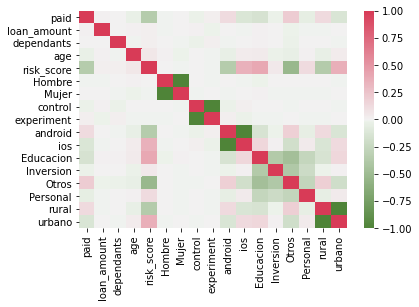

In [56]:
stat_paid=stat[['_1','loan_amount', 'dependants','age', 'risk_score', '_Hombre','_Mujer', '_control','_experiment','_android', '_ios', '_Educacion', '_Inversion', '_Otros', '_Personal', '_rural', '_urbano']]
stat_loan.columns=['paid','loan_amount', 'dependants','age', 'risk_score', 'Hombre','Mujer', 'control','experiment','android', 'ios', 'Educacion', 'Inversion', 'Otros', 'Personal', 'rural', 'urbano']
cmap = sns.diverging_palette(120,6,as_cmap=True)
sns.heatmap(stat_loan.corr(),cmap=cmap)

In [57]:
l = dv.generate_statistics_from_dataframe(loan)
p = dv.generate_statistics_from_dataframe(paid)
dv.visualize_statistics(lhs_statistics=l,
                        rhs_statistics=p)

In [74]:
edu=paid[paid['loan_usage']=='Educacion']


,experiment,loan_amount,dependants,device,loan_usage,age,risk_score,gender,urban_city
1,experiment,2400,2,ios,Educacion,41,0.9410,Mujer,urbano
2,control,1900,0,ios,Educacion,45,0.9450,Mujer,urbano


IF WE CHECK THE CORRELATION GRAPHIC WE CAN SEE THERE IS NOT A WELL DEFINES GROUP, EXCEPT FOR TWO COMPONENTS:
- RISK RATE VALUE (higher than 0.9)
- 'EDUCATION' LOAN USAGE

HOWEVER THOSE CORRELATIONS ARE QUITE WEAK IN BOTH WAYS (POSITIVE AND NEGATIVE). WE CAN SEE THESE INTO THE OTHER CHARTS HERE BELOW.


In [84]:
edu=paid[paid['loan_usage']=='Educacion']

I check risk avg on Education loan usage to prove this: 
it has to be higher than 0.9

In [85]:
np.mean(edu['risk_score'])

0.9327949846018475

LOAN USERS FOR EDUCATIONAL PURPOSES SHOULD HAVE A HIGHER ACCEPTANCE RATE